In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import os
import sys
import matplotlib as mpl
from bokeh.plotting import figure, output_file, ColumnDataSource,show
from bokeh.layouts import row,layout
from bokeh.layouts import column
from bokeh.io import save
from bokeh.layouts import gridplot
from bokeh.models import  CustomJS,Div,DataTable,TableColumn,BooleanFilter,CDSView,CustomJSFilter,CheckboxGroup,ColorBar,Slider
from bokeh.transform import factor_cmap, factor_mark, linear_cmap, transform
import matplotlib as mpl
import colorcet as cc

In [3]:
# read data
df_parkinson = pd.read_excel("./dis.xlsx")
# pca
# pca = PCA(n_components=2)
# x = pca.fit_transform(df_parkinson.iloc[:,:-2])
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(df_parkinson.iloc[:,:-2])

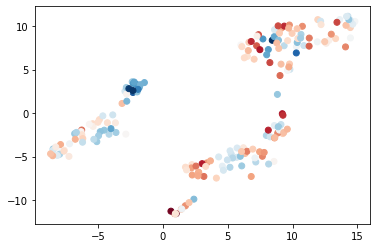

In [4]:
plt.scatter(x_tsne[:,0], x_tsne[:,1],c=np.asarray(df_parkinson['disagree']), cmap='RdBu')

In [5]:
cols = df_parkinson.columns[:5]
X1 = df_parkinson.loc[:, cols]
X1.columns = ['p'+str(i) for i in range(1,6)]
cols = ['p'+str(i) for i in range(1,6)]
X1["x"] = x_tsne[:,0]
X1['y'] = x_tsne[:,1]
X1['disagreement'] = np.asarray(df_parkinson['disagree'], dtype='uint32')
source = ColumnDataSource(X1.to_dict(orient='list'))

In [6]:
source.column_names

['p1', 'p2', 'p3', 'p4', 'p5', 'x', 'y', 'disagreement']

In [7]:
def add_lasso_event(data_source, source2fill):
    data_source.selected.js_on_change(
        'indices', 
        CustomJS(args=dict(s1=data_source, s2=source2fill), 
            code="""
                    var inds = cb_obj.indices;

                    var d1 = s1.data;
                    var d2 = s2.data;

                    d2['p1'] = [];
                    d2['p2'] = [];
                    d2['p3'] = [];
                    d2['p4'] = [];
                    d2['p5'] = [];                

                    for (var i = 0; i < inds.length; i++) {

                        var index = inds[i];
                        d2['p1'].push(d1['p1'][index]);
                        d2['p2'].push(d1['p2'][index]);
                        d2['p3'].push(d1['p3'][index]);
                        d2['p4'].push(d1['p4'][index]);
                        d2['p5'].push(d1['p5'][index]);       
                    }
                    s2.change.emit();
                """)
    )

In [8]:
TOOLS='hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,reset,tap,save,box_select,poly_select,lasso_select'
tooltips = [('{}'.format(k), '@{}'.format(k)) for k in cols]

p = figure(tools=TOOLS, title='learn2use', 
           plot_height=600, plot_width=600)

p.hover.tooltips = tooltips

cm = linear_cmap(field_name='disagreement', palette=cc.cwr ,low=min(X1['disagreement']),
            high=max(X1['disagreement']))
cb = ColorBar(color_mapper = cm['transform'], location = (0,0))

# 挂圈选事件
source_fill = ColumnDataSource(data=dict( [ (k, ['']*200) for k in cols] ) ) # empty
add_lasso_event(source, source_fill)

p.circle('x', 'y'
              , fill_color=cm
              , size=10
              , source=source)

p.add_layout(cb, 'right')
# p.legend.label_text_font_size = '8pt'

In [9]:
layout_list = [[p]]
table_columns = [TableColumn(field=i, title=i) for i in cols]
data_table1 = DataTable(source=source_fill, 
                        columns=table_columns, 
                        width=1200, height=200)
layout_list.append([data_table1])
my_layout=layout(layout_list)

outf = 'parkinson.html'
output_file(outf, title='parkinson_test')
save(obj=my_layout)

'/Users/kadima/experiment_any/anomaly-detection/parkinson.html'